# Assignment Sheet 3

Bruce Schultz  
bschultz@uni-bonn.de

Miguel A. Ibarra-Arellano  
ibarrarellano@gmail.com


## Exercise 1

#### Part a

**Pick the "three clusters with equal numbers of points" data set. Set the number of points per class to 10, and number of dimensions to 50. Once run the demo with perplexity=29, and once with perplexity=30. Explain why there is a big difference in the final 2D embedding?**
* As explained in the article, perplexity is essentially a guess as to how many close neighbors each point has. Since there are a total of 30 points, by making the perplexity equal to 30, it causes the algorithm to fail. The perplexity, therefore, should always be set to a value that is less than the number of points. The first setting, with perplexity equal to 29, holds true to this rule and therefore is able to separate the values into distinct clusters

**Try the example "a square grid with equal spacing between points", with 20 points per side. In the resulting plot with perplexity=100, why are distances between points in the middle of the square larger than near the boundary?**
* t-SNE calculates the interaction of all points with every other point which is computationally expensive. One of the approximtions employed by this technique is to to reduce run time is to approximate the effect of clusters distant from the point. Here, distant clusters are calculated as a single value and their avaerage effect is then applied to the distant point. In this example, the densely packed corners of the shape are all pulling on the center points, so the center is being streched in several directions. The boundaries however have fewer directions in which they are interacting which is part of the reason they are able to become more packed. Ultimately it is the cumalative interaction of the distant points/clusters from all directions that make it so the points in the middle have greater distances between their neighbors compared to the points along the boundaries.

**Pick "a square grid with equal spacing between points" data set, with 20 points per side, and perplexity=2. Run the t-SNE multiple times. You will observe that the square grid sometimes breaks down into separate smaller clusters. Why?**
* As stated before, perplexity loosely defines the number of effective neighbors each dot should have. Additionally, it is known that if the perplexity is set too low for a large dataset, clusters may form when there should not be any due to small-scale variations that occur during the early iterations of calculations. This is also why when we run this simulation several times, it turns out different each time. Perplexity is also linked to the KL divergence that is calculated in that as perplexity increases, you will also get smalled KL-divergence values. With perplexity being so low in this simulation, KL-divergence values are high and false positive clusters form and separate. This shows why it is important to play with this parameter.

**Use different perplexities for "points randomly distributed in a circle" with 100 points. Around what perplexity value does the resulting visualization start to resemble the input data set? Explain why the perplexity has to be large enough for the result to look like the input.**
* When perplexity is set to a value of 10, the simulation begins to consistently generate a visualization that resembles the input data. As mentioned above, small perplexity values allow for meaningless clustering to occur so the points would take odd shapes or even form separate clusters. Perplexity is a parameter that is used to balance global (how points affect each other at a distance) and local (points' effects on those near them) interactions. So if set too low, the "number of effective neighbors" will be too low and the correct number of points will not cluster together yielding a result different from the desired one.



#### Part b

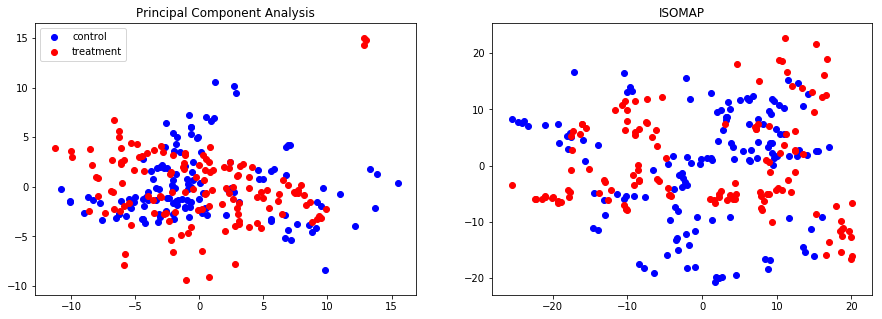

In [9]:
import os
import pandas as pd
from graphviz import Graph
import numpy as np
from scipy import stats
from sklearn import manifold
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from ourStatistics import interpolate_by_mean as ibm, runPCA
from palettable.cmocean.sequential import Dense_3
from palettable.colorbrewer.qualitative import Set2_4

#Read data and interpolate values
cortex_data = pd.read_excel('Data_Cortex_Nuclear.xls').apply(ibm, axis=0)

#Slice data and take only numeric data
cCSs_data = cortex_data[cortex_data['class'] == 'c-SC-s'].select_dtypes(include=[np.number])
tCSs_data = cortex_data[cortex_data['class'] == 't-SC-s'].select_dtypes(include=[np.number])

#Standradize data for PCA
cCSs_data = pd.DataFrame(StandardScaler().fit_transform(cCSs_data))
tCSs_data = pd.DataFrame(StandardScaler().fit_transform(tCSs_data))

#Run PCA
scores_cCSs, loadings_cCSs, summary_cCSs = runPCA(cCSs_data)
scores_tCSs, loadings_tCSs, summary_tCSs = runPCA(tCSs_data)

#Turn data into ISOMAP
def iso(std_data, num_neighbors, num_comp):
    iso = manifold.Isomap(n_neighbors=num_neighbors, n_components=num_comp)
    iso.fit(std_data)
    pre_data = iso.transform(std_data)
    col_list = ["Component {}".format(i) for i in range(1, num_comp+1)]
    return pd.DataFrame(pre_data, columns=col_list)

cCSs_iso = iso(cCSs_data, 10, 2)
tCSs_iso = iso(tCSs_data, 10, 2)

#Plot the 2 side-by-side for comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title("Principal Component Analysis")
ax[0].scatter(scores_cCSs["PC1"], scores_cCSs["PC2"], color='blue', label="control")
ax[0].scatter(scores_tCSs["PC1"], scores_tCSs["PC2"], color='red', label="treatment")

ax[1].set_title("ISOMAP")
ax[1].scatter(cCSs_iso['Component 1'], cCSs_iso['Component 2'], color='blue', label="control")
ax[1].scatter(tCSs_iso['Component 1'], tCSs_iso['Component 2'], color='red', label="treatment")

ax[0].legend(loc="upper left")
fig.savefig('ISOMAP_vs_PCA.png')

Based on these two plots, I would say that ISOMAP would be a better choice since it actually shows distinct clustering. The ISOMAP would thus allow us to better find related genes. 

#### Part c

In [6]:
# Read breast cancer data and interpolate values
bc_data = pd.read_excel('breast-cancer-wisconsin.xlsx').apply(ibm, axis=0)

# Standardize dataset - except class
class_col = bc_data.pop('class')
bc_data_std = pd.DataFrame(StandardScaler().fit_transform(bc_data)) # Standardize
#bc_data_std = pd.DataFrame(MinMaxScaler().fit_transform(bc_data)) # Normalize
bc_data_std['class'] = class_col

# Run t-SNE
def tsne_reduction(pandas_data, n_comps=2, verb=1, perp=30, num_iter=500, initial="random"):
    tsne = TSNE(n_components = n_comps, verbose = verb, perplexity = perp, n_iter=num_iter, init=initial)
    tsne_results = tsne.fit_transform(pandas_data.values)
    col_list = ["Component {}".format(i) for i in range(1, n_comps+1)]
    return pd.DataFrame(tsne_results, columns=col_list)

def remove_outliers(pandas_data, within_std=3):
    '''
    Calculates z score for pandas dataframe and returns dataframe with entries that are within chosen deviation away
    :param pandas_data: Pandas Dataframe of data
    :param within_std: Number of standard deviations away from mean to accept
    :return: Dataframe with rows removed that are outside specified range
    '''
    return pandas_data[(np.abs(stats.zscore(pandas_data)) < within_std).all(axis=1)]

[t-SNE] Computing 1 nearest neighbors...
[t-SNE] Indexed 699 samples in 0.001s...
[t-SNE] Computed neighbors for 699 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 699 / 699
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 206.655197
[t-SNE] Error after 1000 iterations: 7.881104
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 699 samples in 0.001s...
[t-SNE] Computed neighbors for 699 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 699 / 699
[t-SNE] Mean sigma: 1.432152
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.833794
[t-SNE] Error after 1000 iterations: 0.421369
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 699 samples in 0.001s...
[t-SNE] Computed neighbors for 699 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 699 / 699
[t-SNE] Mean sigma: 4.555133
[t-SNE] KL divergence after 250 iterations with early exag

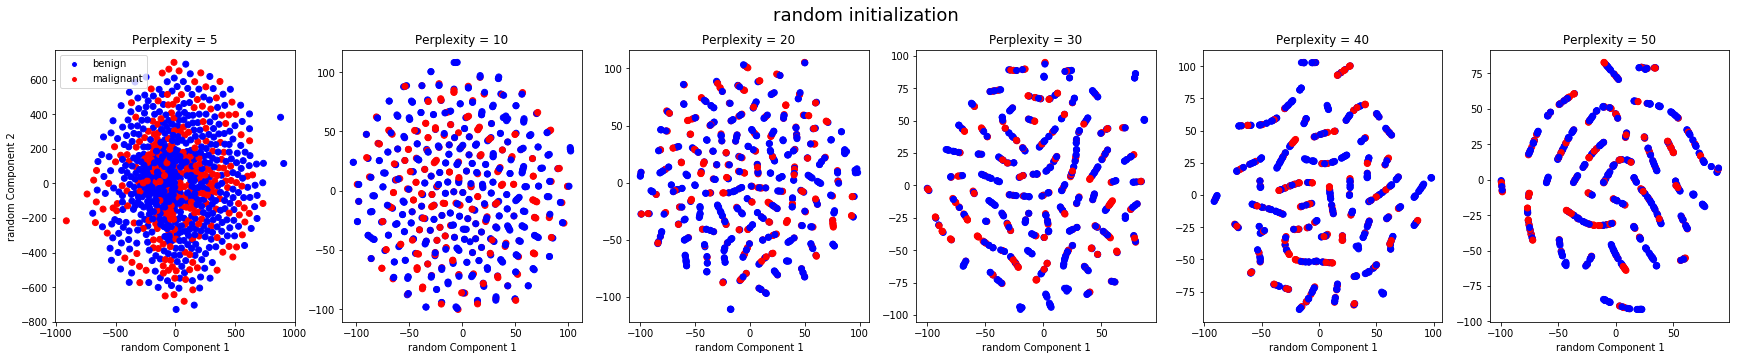

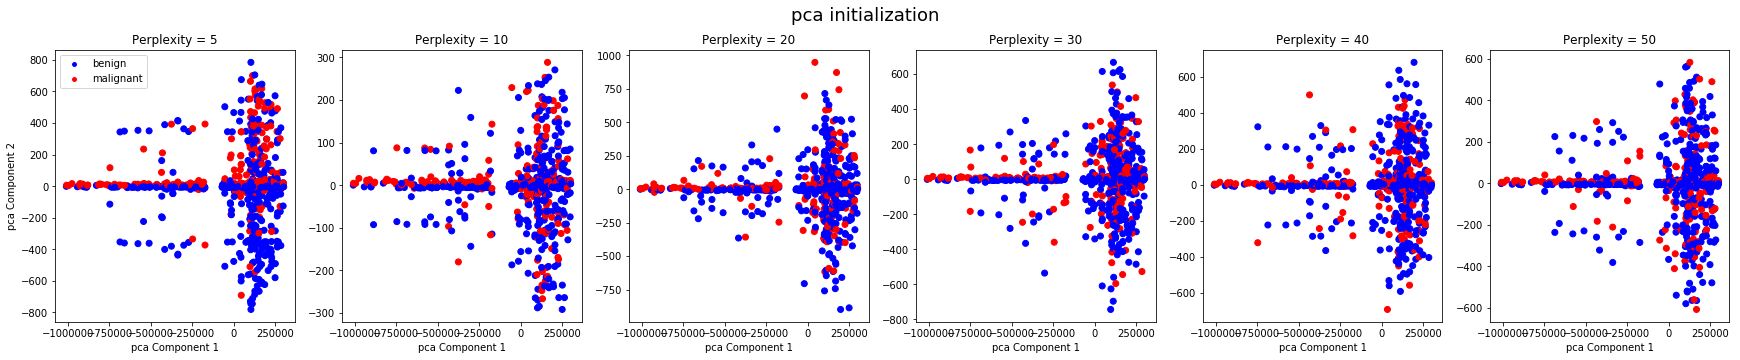

In [8]:
# Create lists of perplexities and initializing schemes to test
perplexities = [5,10,20,30,40,50]
initiate = ['random', 'pca']

# Generate new pandas table for our results
bc_data_tsne = bc_data_std.copy()
colors = ["blue" if row is 2 else "red" for row in list(bc_data_tsne['class'])]
labels = ["benign" if row is 2 else "malignant" for row in list(bc_data_tsne['class'])]
bc_data_tsne['colors'] = colors
bc_data_tsne['labels'] = labels

# Iterate over perplexities and generate subplots
for j in range(len(initiate)):
    # Create initial figure
    fig, ax = plt.subplots(1, len(perplexities), figsize=(30, 5))
    legend_ele = [Line2D([0], [0], color='w', label='benign', marker='o', markerfacecolor='b'),
                  Line2D([0], [0], color='w', label='malignant', marker='o', markerfacecolor='r')]
    ax[0].legend(handles=legend_ele, loc='upper left')
    fig.suptitle("{} initialization".format(initiate[j]), x=0.5, y=1.0, fontsize=18)
    for i in range(len(perplexities)):
        tsne_comps = tsne_reduction(bc_data, perp=i, initial=initiate[j], num_iter=1000)
        
        # Remove outliers to allow us to see clusters/trends
        #tsne_comps = remove_outliers(tsne_comps, within_std=3) # Uses zscore
        tsne_comps = tsne_comps[tsne_comps.apply(lambda x: np.abs(x - x.median()) / x.std() < 3).all(axis=1)] # Median
        
        # Add data to our tsne dataframe
        bc_data_tsne['{}_Perp{}_Component 1'.format(initiate[j], perplexities[i])] = tsne_comps['Component 1']
        bc_data_tsne['{}_Perp{}_Component 2'.format(initiate[j], perplexities[i])] = tsne_comps['Component 2']
        
        # Create graphs
        ax[i].set_title("Perplexity = {}".format(perplexities[i]))
        ax[i].scatter(bc_data_tsne['{}_Perp{}_Component 1'.format(initiate[j], perplexities[i])], \
                      bc_data_tsne['{}_Perp{}_Component 2'.format(initiate[j], perplexities[i])]\
                      , color=colors, label=labels)
        ax[i].set_xlabel("{} Component 1".format(initiate[j]))
        if i == 0:
            ax[i].set_ylabel("{} Component 2".format(initiate[j]))
        fig.savefig("t-SNE_{}".format(initiate[j]))

For both sets of graphs, the data did not nicely separate. However, when we initialize using PCA, we begin to see some separation in the lower values of perplexity. After we get past a perplexity value of 10, the separation begins to disappear. By setting th perplexity too high, the algorithm attempts to make sure each point has more neighbors than it should, and this causes the two groups to begin merging again.

## Exercise 2

Part a  
  
**Using the same dataset as in assignment sheet 2, write code to fill in the missing values. Then compute the Pearson correlation between any pair of variables, and store them in a matrix. (5P)**

In [7]:
# Read file to pandasDF
file_path = "breast-cancer-wisconsin.xlsx"
breast_df = pd.read_excel(os.path.abspath(file_path), index_col="code")

# Fill missing values
benign_imputed = breast_df[breast_df["class"] == 2].apply(ibm, axis=0)
malign_imputed = breast_df[breast_df["class"] == 4].apply(ibm, axis=0)
breast_imputed_df = pd.concat([malign_imputed, benign_imputed])
# breast_df = breast_df.apply(ibm, axis=0)

# Get Pearson Correlation Matrix
breast_corr_df = breast_df.corr(method='pearson', min_periods=1)

Part B  
  
**Install the Graphviz library and its Python interface. Generate and visualize some simple graph. You can find the software and its documentation at https://pypi.python.org/pypi/graphviz. (5P)**

In [8]:
g = Graph("Simple Graph", filename="vclsi-3-Schultz-Ibarra-simple_graph.gv")
g.node("Me")
g.edge("Me", "The girl I like")
g.edge("Her boyfriend", "The girl I like")
g.view()

'vclsi-3-Schultz-Ibarra-simple_graph.gv.pdf'

Part C  
  
**Create a graph from the correlation matrix and visualize it. Represent each variable as a node in the graph. Insert an edge between two variables whenever the Pearson correlation between them exceeds the threshold ρ > 0.6. (4P)**

Part D

**Modify the visual attributes of edges to reflect the magnitude of the correlation. (3P)**

Part E

**Produce an alternative visualization with a circular layout. Color the nodes so that there are four set of nodes, one color for having at least one correlation more than 0.9 to other nodes, another for having at least a correlation 0.8 < ρ max <= 0.9, one for having a correlation 0.6 < ρ max <= 0.8 and the last for the remaining nodes. (5P)**

In [9]:
# Create correlation graph
breast_g = Graph("Breast Cancer", filename="vclsi-3-Schultz-Ibarra-breast_graph.gv", engine="circo")

# Removing diagonal from correlation matrix
breast_corr_df_ndiag = (breast_corr_df[breast_corr_df < 1])
column_max = breast_corr_df_ndiag.max()


def select_color(val):
    """
    selects a color from a value
    :param val: value to which select color
    :return: color for the value
    """
    if val >= 0.9:
        return Set2_4.hex_colors[0]
    elif val >= 0.8:
        return Set2_4.hex_colors[1]
    elif val >= 0.6:
        return Set2_4.hex_colors[2]
    else:
        return Set2_4.hex_colors[3]


# Creating nodes in the graph
for c in breast_corr_df.columns.tolist():
    breast_g.node(c, color=select_color(column_max[c]), style="filled", fillcolor=select_color(column_max[c]))

# Get boolean matrix for values greater than the threshold.
threshold = 0.6
breast_corr_bool = breast_corr_df[breast_corr_df <= threshold].isnull()

# Get color map to use
cmap = Dense_3.mpl_colormap

# Check if correlation coefficient covers the threshold if it does add edge
for i, j in combinations(breast_corr_df.columns.tolist(), r=2):
    if breast_corr_bool.loc[i, j]:
        val = breast_corr_df.loc[i, j]
        breast_g.edge(i, j, color=matplotlib.colors.to_hex(cmap(val)), penwidth=str((val*11)-5))

breast_g.view()


'vclsi-3-Schultz-Ibarra-breast_graph.gv.pdf'

**At the selected threshold, which nodes are disconnected from the rest of the graph and what do they indicate? (1P)**

Only the node "mitoses" is disconnected, it indicates it has a weak correlation with the rest of the variables of the dataset.

**If two nodes A and B are strongly correlated, and node C is strongly correlated with node B, can we conclude that node C will be also strongly correlated with node A? (1P)**

Yes

**Where have you already seen the four nodes connected to node “class” through its thickest edges? (1P)**

BlahCrhoma  
uniCellS  
uniCellShape  
bareNuc  